In [1]:
# You need to have tensorflow, keras, and sciann installed in your system. 
# On google cloud, uncomment next line to install sciann. 

!pip install sciann 
!git clone https://github.com/sciann/sciann-applications.git
!cp /content/sciann-applications/SciANN-Elasticity/sciann_datagenerator.py /content/sciann_datagenerator.py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.5 MB/s 
     |████████████████████████████████| 460.3 MB 7.1 kB/s 
     |████████████████████████████████| 561 kB 75.6 MB/s 
     |████████████████████████████████| 4.0 MB 32.5 MB/s 
     |████████████████████████████████| 132 kB 67.8 MB/s 
     |████████████████████████████████| 14.8 MB 10.6 MB/s 
     |████████████████████████████████| 1.2 MB 48.7 MB/s 
     |████████████████████████████████| 462 kB 74.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68730 sha256=cd89a385455692c65eb8537ceec488949e4b1920a20fb588d066ff43908978f8
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
   

Cloning into 'sciann-applications'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 219 (delta 50), reused 164 (delta 21), pack-reused 0
Receiving objects: 100% (219/219), 17.96 MiB | 22.13 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [2]:
import numpy as np 
from numpy import pi
import matplotlib.pyplot as plt
import sciann as sn 
from sciann_datagenerator import * 

---------------------- SCIANN 0.6.6.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0] 



In [3]:
lmbd = 1.0
mu = 0.5
Q = 4.0

In [4]:
# Neural Network Setup.
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)

Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh')
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')

# Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
# Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')
# Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

lmbd = sn.Parameter(np.random.rand(), name='lmbd', inputs=[x,y])
mu = sn.Parameter(np.random.rand(), name='mu', inputs=[x,y])

C11 = (2*mu + lmbd)
C12 = lmbd
C33 = 2*mu

Exx = sn.diff(Uxy, x)
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5

# c1 = sn.Tie(Sxx, Exx*C11 + Eyy*C12)
# c2 = sn.Tie(Syy, Eyy*C11 + Exx*C12)
# c3 = sn.Tie(Sxy, Exy*C33)

Sxx= Exx*C11 + Eyy*C12
Syy= Eyy*C11 + Exx*C12
Sxy= Exy*C33


Fx = - 1.*(4*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 0.5*(pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 0.5*8*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y)

Fy = 1.0*(3*Q*y**2*sn.sin(pi*x) - 2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x)) \
   - 0.5*(2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x) + (Q*y**4*pi**2*sn.sin(pi*x))/4) \
   + 0.5*6*Q*y**2*sn.sin(pi*x)

Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy


Du = sn.Data(Uxy)
Dv = sn.Data(Vxy)


targets = [Lx, Ly, Du, Dv]

In [5]:
m = sn.SciModel([x, y], targets)

In [6]:
x_data, y_data = np.meshgrid(np.linspace(0.,1.,20), np.linspace(0., 1., 20))

u_data = np.cos(2*pi*x_data) * np.sin(pi*y_data)
v_data = np.sin(pi*x_data) * Q * y_data**4/4
# syy_data = 2*Q*np.sin(pi*y_data)*(y_data==1.)

Lx_data = np.zeros_like(x_data)
Ly_data = np.zeros_like(y_data)

c1_data = np.zeros_like(y_data)
c2_data = np.zeros_like(y_data)
c3_data = np.zeros_like(y_data)

In [8]:
h = m.train([x_data, y_data], [Lx_data, Ly_data, u_data, v_data], #syy_data], 
            batch_size=50, epochs=1, log_parameters={'parameters':[lmbd, mu], 'freq':1}, #recommended epoch 2000
            adaptive_weights={'method':'NTK', 'freq': 100})


Total samples: 400 
Batch size: 50 
Total batches: 8 


+ NTK evaluation time [s]: 6.186802387237549 

+ adaptive_weights at epoch 1: [0.10005298161078968, 0.11917959344836564, 2.1141173622241953, 1.6666500612265338]
8/8 [==============================] - 13s 111ms/step - batch: 3.5000 - size: 50.0000 - loss: 197.7314 - sub_7_loss: 1655.7612 - sub_8_loss: 258.8564 - Uxy_loss: 0.4768 - Vxy_loss: 0.1254 - lr: 0.0010 - time: 19.1826 - loss_weight_0: 0.1001 - loss_weight_1: 0.1192 - loss_weight_2: 2.1141 - loss_weight_3: 1.6667 - loss_gradient_0: 4101.7921 - loss_gradient_1: 4062.4336 - loss_gradient_2: 162.5121 - loss_gradient_3: 203.1803 - lmbd: 0.3474 - mu: 0.6610


In [9]:
h.history.keys()

dict_keys(['loss', 'sub_7_loss', 'sub_8_loss', 'Uxy_loss', 'Vxy_loss', 'lr', 'time', 'loss_weight_0', 'loss_weight_1', 'loss_weight_2', 'loss_weight_3', 'loss_gradient_0', 'loss_gradient_1', 'loss_gradient_2', 'loss_gradient_3', 'lmbd', 'mu'])

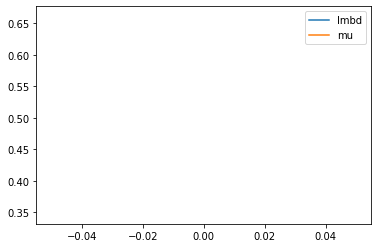

In [12]:
plt.plot(h.history['lmbd'], label='lmbd')
plt.plot(h.history['mu'], label='mu')
plt.legend()

In [13]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

In [14]:
test_data = {
    'u': Uxy.eval([x_test, y_test]),
    'v': Vxy.eval([x_test, y_test]),
    'sxx': Sxx.eval([x_test, y_test]),
    'syy': Syy.eval([x_test, y_test]),
    'sxy': Sxy.eval([x_test, y_test])
}

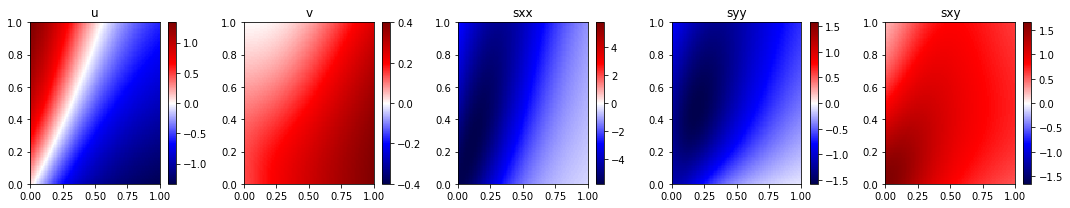

In [16]:
def cust_plot(ax, val, label):
    im = ax.pcolor(x_test, y_test, val, cmap='seismic', 
                   vmin=-np.abs(val).max(), vmax=np.abs(val).max())
    ax.set_title(label)
    plt.colorbar(im, ax=ax)
    
fig, ax = plt.subplots(1,5,figsize=(15,3))
for i, (key, val) in enumerate(test_data.items()):
    cust_plot(ax[i], val, key)
    
plt.tight_layout()
plt.show()